In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.layers import multiply

C:\Users\victo\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Define the model

In [3]:
from keras import optimizers
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

In [4]:
import json
from sklearn import preprocessing
from utils import preprocess_data, topKFrequentAnswer, getVoc
from features_processor import getEmbeddings
data_question = json.load(open('Questions/OpenEnded_mscoco_train2014_questions.json')) # removed v2_
data_answer = json.load(open('Annotations/mscoco_train2014_annotations.json'))

data_qval = json.load(open('Questions/OpenEnded_mscoco_val2014_questions.json'))
data_aval = json.load(open('Annotations/mscoco_val2014_annotations.json'))

In [5]:
K_train_dict, K_val_dict, topKAnswers = topKFrequentAnswer(data_question, data_answer, data_qval, data_aval)

K_images_id, K_questions_id, K_questions, K_questions_len, K_answers = K_train_dict['images_id'], K_train_dict['questions_id'], K_train_dict['questions'], K_train_dict['questions_len'], K_train_dict['answers']
K_images_val_id, K_questions_val_id, K_questions_val, K_questions_val_len, K_answers_val = K_val_dict['images_id'], K_val_dict['questions_id'], K_val_dict['questions'], K_val_dict['questions_len'], K_val_dict['answers']

vocabulary = getVoc(K_questions, K_questions_val)
embedding_matrix = getEmbeddings(vocabulary)

In [6]:
img_dim = 4096
word2vec_dim = 300
hidden_layers = 2

merge_hidden_units = 1024
q_hidden_units = 512
mlp_hidden_units = 1000

voc_size = len(vocabulary) # number of unique words from training + validation questions
max_len = max(max(K_questions_len), max(K_questions_val_len)) + 1 # max number of words per question
dropout = 0.5
activation = 'tanh'
nb_classes = len(topKAnswers) # 1000

In [7]:
from keras.layers import *

# image model
i_model = Sequential()
i_model.add(Dense(merge_hidden_units, input_shape=(img_dim,)))
i_model.add(Activation(activation))
#i_model.add(Dropout(dropout))


# question model
q_model = Sequential()
q_model.add(Embedding(voc_size, word2vec_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
q_model.add(LSTM(units=q_hidden_units, return_sequences=True, input_shape=(max_len, word2vec_dim)))
q_model.add(Dropout(dropout))
q_model.add(LSTM(q_hidden_units, return_sequences=False))
q_model.add(Dropout(dropout))
q_model.add(Dense(merge_hidden_units))
q_model.add(Activation(activation))


# Merging
# add embedding
merge_model = Multiply()([i_model.output, q_model.output])
for i in range(hidden_layers):
    merge_model = (Dense(mlp_hidden_units,))(merge_model)
    merge_model = (Activation(activation))(merge_model)
    merge_model = (Dropout(dropout))(merge_model)

merge_model = (Dense(nb_classes,))(merge_model)
merge_model = (Activation('softmax'))(merge_model)

model = Model([q_model.input, i_model.input], merge_model)

rmsprop = optimizers.RMSprop(lr=3e-4, rho=0.9, epsilon=1e-08, decay=0)
#adam = optimizers.Adam(lr=4e-4, beta_1=0.8, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

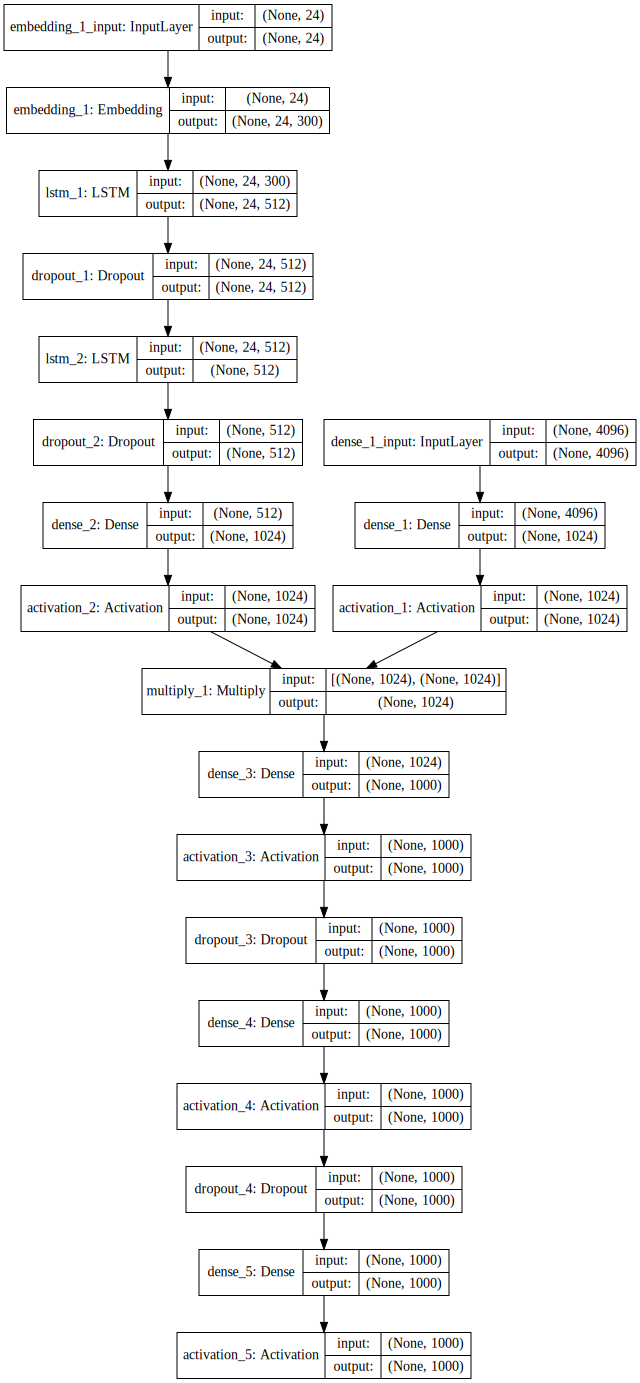

In [8]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [9]:
labelencoder = preprocessing.LabelEncoder()
labelencoder.fit(topKAnswers)

LabelEncoder()

## Evaluate the model

### test on a single question

In [10]:
from features_processor import question_features, qtot

In [11]:
data_test = json.load(open('Questions/OpenEnded_mscoco_test-dev2015_questions.json')) # removed v2_
img_test = json.load(open('COCO/annotations/image_info_test2014.json')) # 2015 before

In [12]:
def img_id_to_path(data_test, img_test):
    d = dict()
    imgtopath = dict()
    
    for img_info in img_test['images']:
        img_id = img_info['id']
        d[img_id] = img_info['file_name']
        
    for q in data_test['questions']:
        q_id = q['question_id']
        
        imgtopath[q_id] = d[q['image_id']]
        
    return imgtopath

In [13]:
qid_to_imgpath = img_id_to_path(data_test, img_test)

#### don't forget to load the weights

In [14]:
model.load_weights('weights/LSTMQ_I/weights.12-2.08.hdf5')

#### load the embeddings for the test dataset + dict that maps image_id to index in matrix

In [15]:
import scipy.io

In [16]:
# load the embeddings for the test dataset into memory to speed the process
features_test = scipy.io.loadmat('preprocess_datas/VGG16_feats_test.mat')['features']

# Load dictionary that maps image_id to index in the matrix X of size (4096, nb_test_imgs)
img_id_to_idx = json.load(open('preprocess_datas/id_img_test_to_index.json'))

In [17]:
import matplotlib.pyplot as plt
import imageio
import numpy as np
%matplotlib inline
from features_processor import qtotIndex

### Test our model on a single image of the validation image dataset

question:  What color top is the person wearing?
top-1 answer: green with probabiliy: 45.16
top-2 answer: yellow with probabiliy: 30.04
top-3 answer: blue with probabiliy: 4.62
top-4 answer: brown with probabiliy: 4.19
top-5 answer: black with probabiliy: 2.98


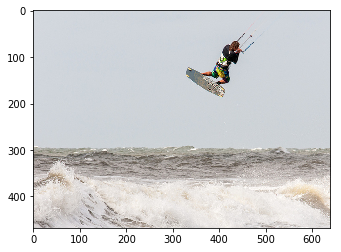

In [18]:
idx = 7898 # idx of question

print("question: ", data_test['questions'][idx]['question'])

img_path = 'COCO/images_test/' + qid_to_imgpath[data_test['questions'][idx]['question_id']]
plt.imshow(imageio.imread(img_path))

question_feat = qtotIndex([data_test['questions'][idx]['question']], vocabulary, max_len)
idx_mat = img_id_to_idx["%s" % data_test['questions'][idx]['image_id']]
image_feat = (features_test[:, idx_mat] / np.linalg.norm(features_test[:, idx_mat])).reshape(1,-1)

final_proba = model.predict([question_feat, image_feat])
top5_ans = np.argsort(final_proba)[0][::-1][:5]
for i, a in enumerate(top5_ans, 1):
    print("top-%d answer: %s with probabiliy: %.02f" % (i, labelencoder.inverse_transform(a), 100 * final_proba[0][a]))

### Test our model on our image and question

In [19]:
import models.vgg16 as my_model

top-1 answer: 2 with probabiliy: 67.67
top-2 answer: 3 with probabiliy: 17.11
top-3 answer: 4 with probabiliy: 6.49
top-4 answer: 1 with probabiliy: 4.96
top-5 answer: 5 with probabiliy: 1.31


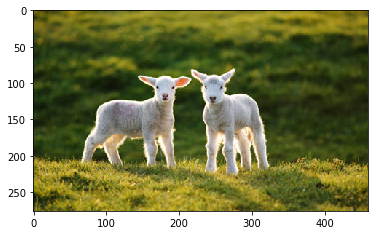

In [20]:
# bus example (Note: the question should end by an ? next to the final word!)
# question = 'What color is the bus?'
# img_path = 'our_images/bus.jpg'

question = 'How many sheeps do you see?'
img_path = 'our_images/sheeps.jpg'

plt.imshow(imageio.imread(img_path))
question_feat = qtotIndex([question], vocabulary, max_len)
image_feat = my_model.extract_features(img_path, my_model.vgg16_model_extractfeatures)

final_proba = model.predict([question_feat, image_feat])
top5_ans = np.argsort(final_proba)[0][::-1][:5]
for i, a in enumerate(top5_ans, 1):
    print("top-%d answer: %s with probabiliy: %.02f" % (i, labelencoder.inverse_transform(a), 100 * final_proba[0][a]))

## Compute the final accuracy of the model
We compute the final accuracy of the model using the formula:

$$\text{accuracy} = min(\frac{\text{# humans that provided that answer}}{3}, 1)$$

We do that on the validation set as we don't have access to the ground truth answers from the testing set and the website that provides the ground truth answers was updated with the ground truth answers of the 2017 dataset. As we are working on the 2015 version to be able to compare our results with the paper's results we are force to compute the accuracy on the validation set.

In [21]:
# load the embeddings for the test dataset into memory to speed the process
features = scipy.io.loadmat('preprocess_datas/VGG16_feats.mat')['features']

# Load dictionary that maps image_id to index in the matrix X of size (4096, nb_test_imgs)
img_id_to_idx = json.load(open('preprocess_datas/id_image_to_index.json'))

In [38]:
available_img_id = {v: 0 for v in K_questions_val_id}

In [30]:
# construct a list with the predicted answer from the model
pred_answers = []

i = 0

print(len(data_qval['questions']))

for ques in data_qval['questions']:
    if ques['question_id'] in available_img_id:

        q_feat = qtotIndex([ques['question']], vocabulary, max_len)
        idx_mat = img_id_to_idx["%s" % ques['image_id']]
        i_feat = (features[:, idx_mat] / np.linalg.norm(features[:, idx_mat])).reshape(1,-1)

        pred = np.argmax(model.predict([q_feat, i_feat]))
        if i % 10000 == 0:
            print(i, end='', flush=True)
        pred_answers.append(labelencoder.inverse_transform(pred))
#         print(i+1, ques['question'])
#         print(labelencoder.inverse_transform(pred))
        i += 1

121512
0100002000030000400005000060000700008000090000100000

In [32]:
import csv
i = 0
true_multiple_answers = []

with open('preprocess_datas/multiple_answers.csv', 'r') as f:
    wr = csv.reader(f, quoting=csv.QUOTE_NONE)
    for row in wr:
        true_multiple_answers.append(row)

In [40]:
c = 0.0
cat_counter = {'yes/no': 0, 'other': 0, 'number': 0, 'all': 0}
cat = {'yes/no': 0, 'other': 0, 'number': 0, 'all': 0}


img_ptr = 0
q_ptr = 0

for obj in data_aval['annotations']:
    if (obj['image_id'] == K_images_val_id[img_ptr] and 
        obj['question_id'] == K_questions_val_id[q_ptr]):
        
        cat_counter[obj['answer_type']] += 1

        count = true_multiple_answers[img_ptr].count(pred_answers[img_ptr])
        if count > 2:
            cat[obj['answer_type']] += 1
            c += 1
        else:
            cat[obj['answer_type']] += float(count)/3
            c += float(count)/3
        
        img_ptr += 1
        q_ptr += 1

print('other accuracy on validation set: %.02f' % (100 * cat['other']/cat_counter['other']))
print('number accuracy on validation set: %.02f' % (100 * cat['number']/cat_counter['number']))
print('yes/no accuracy on validation set: %.02f' % (100 * cat['yes/no']/cat_counter['yes/no']))
print('final accuracy on validation set: %.02f' % (100 * c/len(data_aval['annotations'])))

other accuracy on validation set: 43.45
number accuracy on validation set: 38.44
yes/no accuracy on validation set: 79.24
final accuracy on validation set: 50.30
